# 样式迁移

- 将样式图片中的样式，迁移到内容图片上，得到合成图片
<img src="./pic/样式迁移1.PNG" width=400 height=400>
- Content image内容保持不变，但替换成Style image的风格，就会得到合成的图片
<img src="./pic/样式迁移2.PNG" width=400 height=400>

## 基于CNN的样式迁移

- 三张图片的神经网络是同一个。
- 训练一张合成图，使内容与content imgage一样，样式与style image一样
- 合成图的神经网络，**部分cnn层在内容上匹配内容图片，部分cnn层在样式上匹配样式图片**
    - 在训练合成图时，如果同时满足以上2个部分，则**既保留了内容，也保留的样式**
- total variation loss低 = 合成图的噪点低

<img src="./pic/基于CNN的样式迁移1.PNG" width=400 height=400>

- 如何定义内容一样？如何定义样式一样？
- 不是训练卷积网络的权重，而是训练合成图

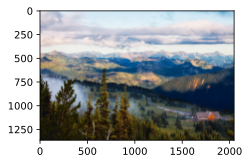

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
content_img = d2l.Image.open('./pic/rainier.jpg')
d2l.plt.imshow(content_img);

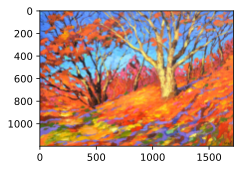

In [2]:
style_img = d2l.Image.open('./pic/autumn-oak.jpg')
d2l.plt.imshow(style_img);

## 预处理和后处理

In [3]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

# 图片变为一个可以训练的tensor
def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0)

# tensor变回图片
def postprocess(img):
    img = img[0].to(rgb_std.device)
    # 之所以clamp的区间是0到1，而非0到255，是因为totensor除以了255
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)    
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

## 抽取图像特征

- 使用基于ImageNet数据集预训练的VGG-19模型来抽取图像特征

In [4]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

# 越小越靠近输入，越大越靠近输出
style_layers, content_layers = [0, 5, 10, 19, 28], [25]
# [0, 5, 10, 19, 28] 包含（0,5,10）局部的样式，和（28）全局的样式
# 内容则相对靠后（25）。越靠近底层（小），内容的还原越好。由于不需要还原内容，可以允许变形

# 丢掉28层之后的卷积层
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])

- 给定输入X，如果我们简单地调用前向传播net(X)，只能获得最后一层的输出。 由于我们还需要中间层的输出，因此这里我们逐层计算，并保留内容层和风格层的输出。

In [5]:
# 抽特征
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        # 如果i层是样式层，则返回样式层。如果i层是内容层，则返回内容层
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

# 不改变内容图片和样式图片，也不改变cnn的权重。所以特征可以一开始全部抽出来

# 拿出内容
def get_contents(image_shape, device):
    # 把内容图片转成tensor形式
    content_X = preprocess(content_img, image_shape).to(device)
    # 输入该tensor用于抽取特征，放入contents_Y
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y


# 拿出样式
def get_styles(image_shape, device):
    # 把样式图片转成tensor形式
    style_X = preprocess(style_img, image_shape).to(device)
    # 输入该tensor用于抽取特征，styles_Y
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y


## 定义损失函数

- 由内容损失、风格损失和全变分损失3部分组成
- 内容损失
    - 与线性回归中的损失函数类似，内容损失通过平方误差函数衡量合成图像与内容图像在内容特征上的差异。 平方误差函数的两个输入均为extract_features函数计算所得到的内容层的输出。
- 风格损失
    - RGB直方图
    - 匹配通道里面的统计分布和通道之间的统计分布
    - 1阶统计信息：均值
    - 2阶统计信息：协方差，gram matrix(格拉姆矩阵)
    - 3阶统计信息：3阶矩阵
    - 4阶统计信息：4阶矩阵
    
- 全变分损失（降噪损失）：（total variation loss）
    - 匹配每个像素与其上下左右的像素之间的绝对值，不要差太多。使图片平均，减少早点

In [6]:
# Y_hat：生成图片的内容（卷积层）输出
# Y：真实内容图片（卷积层）输出
def content_loss(Y_hat, Y):
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat - Y.detach()).mean()
# 因为内容图片和样式图片不用更新，所以Y不用更新，都是Y.detach()


def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    # 使每个不同的层，抽出的gram matrix的数值差不多
    return torch.matmul(X, X.T) / (num_channels * n)


def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()


def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

## 计算损失函数

In [7]:
content_weight, style_weight, tv_weight = 1, 1e4, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、风格损失和全变分损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

# 初始化合成图像

- 在风格迁移中，**合成的图像是训练期间唯一需要更新的变量**。因此，我们可以定义一个简单的模型SynthesizedImage，并将合成的图像视为模型参数。模型的前向传播只需返回模型参数即可。

- **不需要训练卷积神经网络权重**

In [8]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight    # 可以对weight算梯度，进行更新

- 下面，我们定义get_inits函数。该函数创建了合成图像的模型实例，并将其初始化为图像X。风格图像在各个风格层的格拉姆矩阵styles_Y_gram将在训练前预先计算好。

In [9]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer    

# 训练模型

In [10]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)    # 把内容图片作为初始图片
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

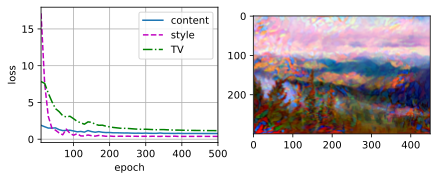

In [11]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

In [ ]:
- 对输入算梯度，然后不断的迭代梯度。而不是算卷积神经网络的权重
- 卷积只是用来抽取图片特征，不更新，不参与训练
- 模型的权重可以理解成合成图片本身